In [62]:
import pandas as pd
import numpy as np

data_path = "data/"

In [63]:
df_train = pd.read_csv(data_path + "time_series_train_data.csv")
df_test = pd.read_csv(data_path + "time_series_test_data.csv")
df_train

,Location Group,District,Year,Month,crime_count,holiday_count,sin_month,cos_month,crime_count_lag1,crime_count_lag2,crime_count_lag3,crime_count_lag6,crime_count_lag12,crime_count_ma3,crime_count_ma6
0,EDUCATIONAL,1.0,2019,1,22,2,0.000000,1.000000e+00,24.0,31.0,16.0,25.0,21.0,23.666667,23.333333
1,EDUCATIONAL,1.0,2019,2,14,1,0.500000,8.660254e-01,29.0,13.0,37.0,17.0,6.0,26.333333,24.666667
2,EDUCATIONAL,1.0,2019,3,26,0,0.866025,5.000000e-01,24.0,27.0,9.0,24.0,18.0,20.000000,27.166667
3,EDUCATIONAL,1.0,2019,4,21,0,1.000000,6.123234e-17,25.0,12.0,44.0,11.0,21.0,27.000000,23.500000
4,EDUCATIONAL,1.0,2019,5,25,1,0.866025,-5.000000e-01,14.0,36.0,22.0,26.0,78.0,24.000000,31.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14422,TRANSPORTATION,25.0,2023,9,31,1,-0.866025,-5.000000e-01,11.0,25.0,19.0,30.0,13.0,18.333333,23.833333
14423,TRANSPORTATION,25.0,2023,10,39,1,-1.000000,-1.836970e-16,23.0,118.0,24.0,36.0,28.0,55.000000,47.833333
14424,TRANSPORTATION,25.0,2023,11,41,2,-0.866025,5.000000e-01,6.0,43.0,67.0,29.0,43.0,38.666667,34.000000
14425,TRANSPORTATION,25.0,2023,12,34,1,-0.500000,8.660254e-01,29.0,39.0,45.0,84.0,23.0,37.666667,39.166667


In [64]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [65]:
categorical_cols = ["Location Group", "District"]
numerical_cols = [
    "crime_count_lag1",
    "crime_count_lag2",
    "crime_count_lag3",
    "crime_count_lag12",
    "crime_count_ma3",
    "crime_count_ma6",
    "holiday_count",
    "sin_month",
    "cos_month",
    "Year",
    "Month",
]

# Split features and target
X_train = df_train[categorical_cols + numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[categorical_cols + numerical_cols]
y_test = df_test["crime_count"]

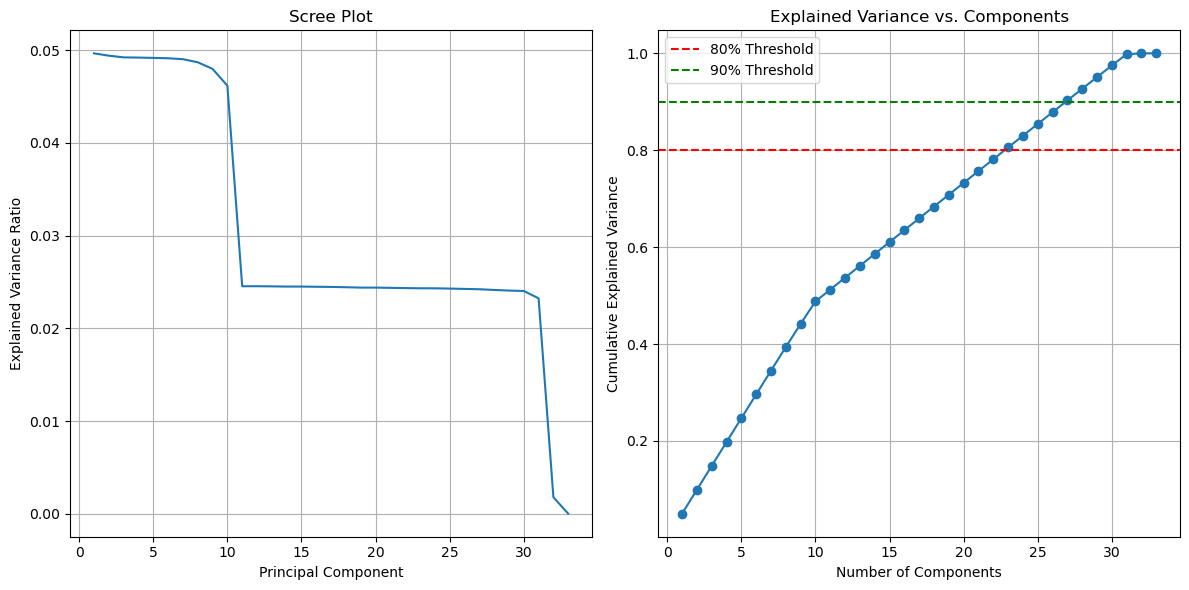

In [66]:
from sklearn.decomposition import PCA

ohc = OneHotEncoder(handle_unknown="ignore")
X_coded = ohc.fit_transform(X_train[categorical_cols])
pca = PCA(n_components=X_coded.shape[1] - 1, random_state=42)
pca_result = pca.fit_transform(X_coded)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)

# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Components")
plt.axhline(y=0.8, color="r", linestyle="--", label="80% Threshold")
plt.axhline(y=0.9, color="g", linestyle="--", label="90% Threshold")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat_pipe", cat_pipe, categorical_cols),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())],
)

In [68]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['crime_count_lag1',
                                                   'crime_count_lag2',
                                                   'crime_count_lag3',
                                                   'crime_count_lag12',
                                                   'crime_count_ma3',
                                                   'crime_count_ma6',
                                                   'holiday_count', 'sin_month',
                                                   'cos_month', 'Year',
                                                   'Month']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location Group',
                                                   'District'])])),
                ('regressor', LinearRegression())])

In [69]:
lr_train_pred = model.predict(X_train)
lr_pred = model.predict(X_test)

In [70]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics
rmse = root_mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)
mean_value = y_test.mean()
print(mean_value)
mae_percentage = (mae / mean_value) * 100

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error Percentage: {mae_percentage:.2f}%")

88.79227053140097
Root Mean Squared Error: 53.61
Mean Absolute Error: 33.67
R² Score: 0.84
Mean Absolute Error Percentage: 37.91%


# Random Forest Regressor


In [71]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [72]:
from sklearn.ensemble import RandomForestRegressor

# Same preprocessing pipeline, but switch out the regressor
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_pred = rf_model.predict(X_test)

In [73]:
# Evaluate the model
rf_rmse = root_mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae_percentage = (rf_mae / y_test.mean()) * 100

print(f"Random Forest Results:")
print(f"Root Mean Squared Error: {rf_rmse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"Mean Absolute Error Percentage: {rf_mae_percentage:.2f}%")

Random Forest Results:
Root Mean Squared Error: 22.42
Mean Absolute Error: 12.38
R² Score: 0.97
Mean Absolute Error Percentage: 13.95%


In [74]:
from xgboost import XGBRegressor

xg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        (
            "regressor",
            XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=7,
                min_child_weight=5,
                gamma=0.1,
                random_state=42,
            ),
        ),
    ]
)
xg_model.fit(X_train, y_train)
xg_train_pred = xg_model.predict(X_train)
xg_pred = xg_model.predict(X_test)

In [75]:
# Evaluate the model
xg_rmse = root_mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_r2 = r2_score(y_test, xg_pred)
xg_mae_percentage = (xg_mae / y_test.mean()) * 100
print(f"XGBoost Results:")
print(f"Root Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Error: {xg_mae:.2f}")
print(f"R² Score: {xg_r2:.2f}")
print(f"Mean Absolute Error Percentage: {xg_mae_percentage:.2f}%")

XGBoost Results:
Root Mean Squared Error: 23.46
Mean Absolute Error: 13.29
R² Score: 0.97
Mean Absolute Error Percentage: 14.96%


In [76]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    "regressor__n_estimators": [200],
    "regressor__learning_rate": [0.1],
    "regressor__max_depth": [5, 7, 9],
    "regressor__min_child_weight": [5],
    "regressor__gamma": [0.1],
}

# Create the pipeline with XGBRegressor
xg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=42))]
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Display progress
)

# Fit the grid search to the data
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best parameters: {best_params}")

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Testing metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing R²: {test_r2:.4f}")

# Store residuals for plotting
xg_res = y_test - y_test_pred

Starting grid search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Grid search completed!
Best parameters: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 200}

Model Performance:
Training RMSE: 17.1640
Training R²: 0.9824
Testing RMSE: 24.4886
Testing R²: 0.9669


In [77]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

cols_to_drop = [
    "crime_count_lag1",
    "crime_count_lag2",
    "crime_count_lag3",
    "crime_count_lag6",
    "crime_count_lag12",
    "crime_count_ma3",
    "crime_count_ma6",
]
df_reduced_train = df_train.drop(columns=cols_to_drop)
df_reduced_test = df_test.drop(columns=cols_to_drop)

features = [
    "Location Group",
    "District",
    "holiday_count",
    "sin_month",
    "cos_month",
    "Year",
    "Month",
]
target = "crime_count"

df_encoded_train = pd.get_dummies(
    df_reduced_train, columns=["Location Group", "District"], drop_first=True
)
df_encoded_test = pd.get_dummies(
    df_reduced_test, columns=["Location Group", "District"], drop_first=True
)
df_encoded_train

,Year,Month,crime_count,holiday_count,sin_month,cos_month,Location Group_FINANCIAL,Location Group_FOOD_ENTERTAINMENT,Location Group_GOVERNMENT,Location Group_OFFICE_BUSINESS,...,District_15.0,District_16.0,District_17.0,District_18.0,District_19.0,District_20.0,District_22.0,District_24.0,District_25.0,District_31.0
0,2019,1,22,2,0.000000,1.000000e+00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2019,2,14,1,0.500000,8.660254e-01,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2019,3,26,0,0.866025,5.000000e-01,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2019,4,21,0,1.000000,6.123234e-17,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2019,5,25,1,0.866025,-5.000000e-01,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14422,2023,9,31,1,-0.866025,-5.000000e-01,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
14423,2023,10,39,1,-1.000000,-1.836970e-16,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
14424,2023,11,41,2,-0.866025,5.000000e-01,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
14425,2023,12,34,1,-0.500000,8.660254e-01,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
numeric_cols = ["holiday_count", "sin_month", "cos_month", "Year", "Month"]
from sklearn.preprocessing import MinMaxScaler


minmax = MinMaxScaler()
X_train = df_encoded_train[
    [col for col in df_encoded_train.columns if col != target]
].astype("float32")
y_train = df_encoded_train[target].astype("float32")
X_test = df_encoded_test[
    [col for col in df_encoded_test.columns if col != target]
].astype("float32")
y_test = df_encoded_test[target].astype("float32")
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)
X_train_seq = X_train_scaled.reshape(
    X_train_scaled.shape[0], 1, X_train_scaled.shape[1]
)
X_test_seq = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [88]:
# deprecated: use pytorch version
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Define the model with explicit Input layer
# model = Sequential()
# model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
# model.add(LSTM(128, activation="sigmoid"))
# model.add(Dropout(0.2))
# model.add(Dense(1))  # Output layer for predicting crime_count
# model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001)),

# # Fit the model on the training set
# model.fit(X_train_seq, y_train.values, epochs=100, batch_size=64, verbose=2)

# # Evaluate on the test set
# test_loss = model.evaluate(X_test_seq, y_test.values, verbose=2)
# print("Test Loss (MSE):", test_loss)

In [89]:
# use pytorch version
# lstm_train_pred = model.predict(X_train_seq)
# lstm_predict = model.predict(X_test_seq)
# lstm_rmse = root_mean_squared_error(y_test, lstm_predict)
# lstm_mae = mean_absolute_error(y_test, lstm_predict)
# lstm_r2 = r2_score(y_test, lstm_predict)
# lstm_mae_percentage = (lstm_mae / y_test.mean()) * 100
# print(f"LSTM Results:")
# print(f"Root Mean Squared Error: {lstm_rmse:.2f}")
# print(f"Mean Absolute Error: {lstm_mae:.2f}")
# print(f"R² Score: {lstm_r2:.2f}")
# print(f"Mean Absolute Error Percentage: {lstm_mae_percentage:.2f}%")

In [90]:
df_train["lr_pred"] = lr_train_pred
df_train["rf_pred"] = rf_train_pred
df_train["xg_pred"] = xg_train_pred
df_test["lr_pred"] = lr_pred
df_test["rf_pred"] = rf_pred
df_test["xg_pred"] = xg_pred


# Add residuals (actual - predicted)
df_train["lr_res"] = df_train["crime_count"] - df_train["lr_pred"]
df_train["rf_res"] = df_train["crime_count"] - df_train["rf_pred"]
df_train["xg_res"] = df_train["crime_count"] - df_train["xg_pred"]
df_train["lstm_res"] = df_train["crime_count"] - df_train["lstm_pred"]
df_test["lr_res"] = df_test["crime_count"] - df_test["lr_pred"]
df_test["rf_res"] = df_test["crime_count"] - df_test["rf_pred"]
df_test["xg_res"] = df_test["crime_count"] - df_test["xg_pred"]
df_test["lstm_res"] = df_test["crime_count"] - df_test["lstm_pred"]

Montly MAE and MAE Accuracy for each model on test data:
Linear Regression MAE:  771.6448241162389
Linear Regression MAE Accuracy:  8.690451
Random Forest MAE:  730.8250000000002
Random Forest MAE Accuracy:  8.230728
XGBoost MAE:  695.8219604492188
XGBoost MAE Accuracy:  7.8365154


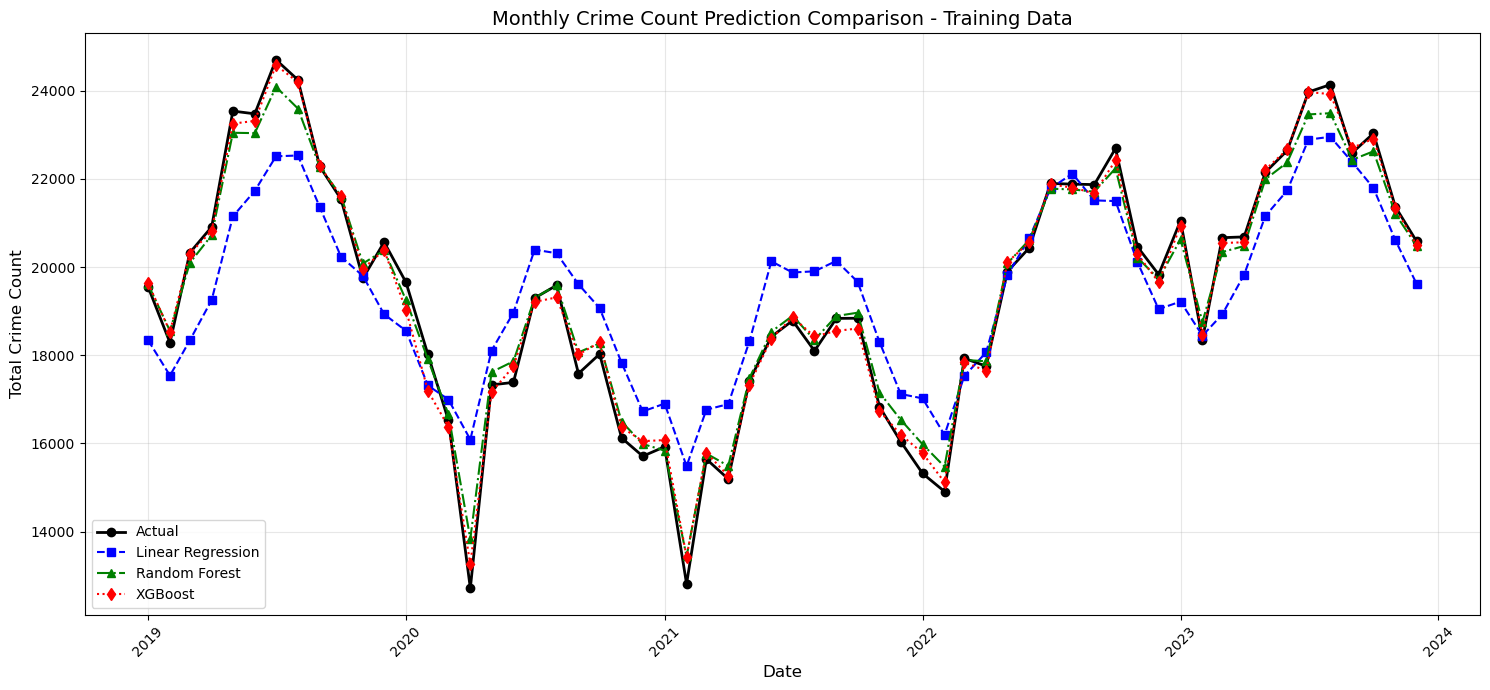

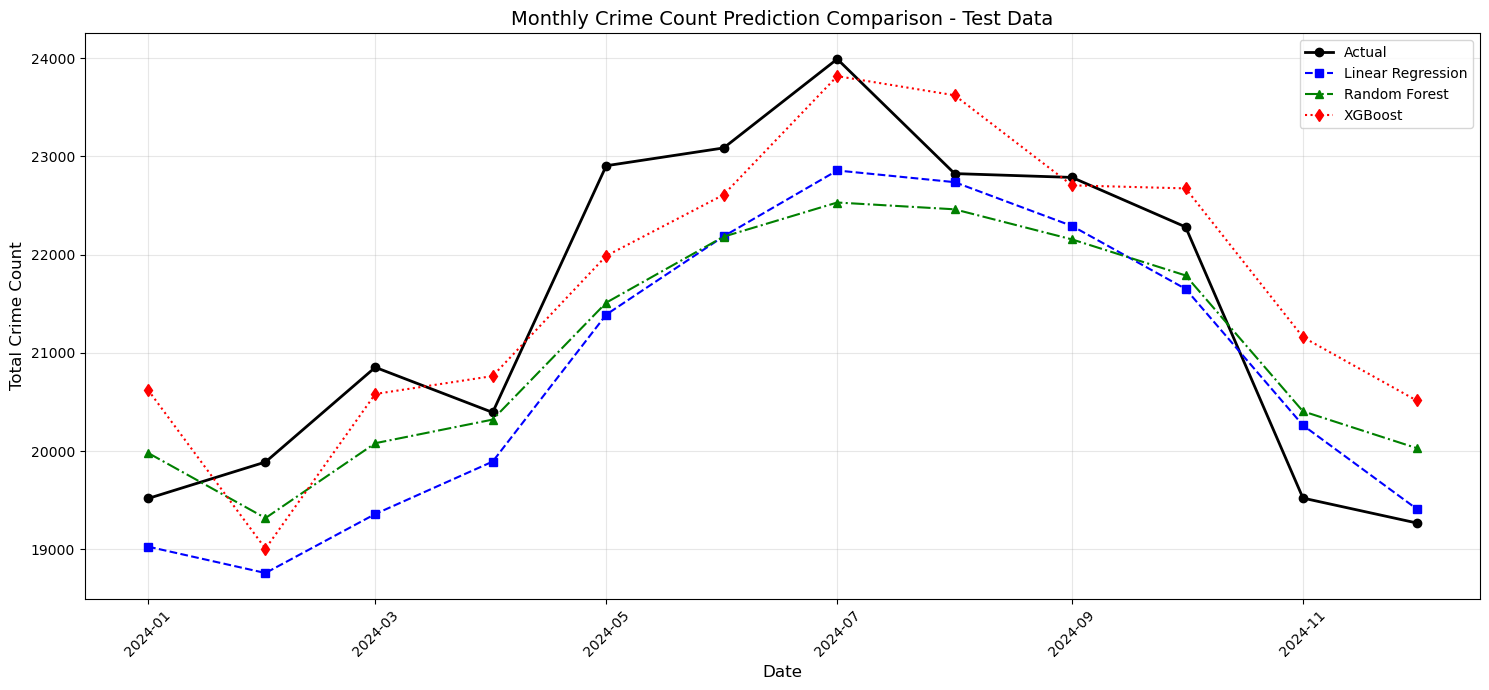

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. MONTHLY AGGREGATION PLOTS
# ============================

# Aggregate by month
monthly_train = (
    df_train.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
        }
    )
    .reset_index()
)

monthly_test = (
    df_test.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
        }
    )
    .reset_index()
)

# Create date columns
monthly_train["date"] = pd.to_datetime(
    monthly_train["Year"].astype(str) + "-" + monthly_train["Month"].astype(str) + "-01"
)
monthly_test["date"] = pd.to_datetime(
    monthly_test["Year"].astype(str) + "-" + monthly_test["Month"].astype(str) + "-01"
)

# Sort by date
monthly_train = monthly_train.sort_values("date")
monthly_test = monthly_test.sort_values("date")

y_test_monthly = monthly_test["crime_count"]
# print mean absolute error and mean absolute error accuracy for each model
print("Montly MAE and MAE Accuracy for each model on test data:")
print(
    "Linear Regression MAE: ",
    mean_absolute_error(y_test_monthly, monthly_test["lr_pred"]),
)
print(
    "Linear Regression MAE Accuracy: ",
    mean_absolute_error(y_test_monthly, monthly_test["lr_pred"]) / y_test.mean(),
)
print(
    "Random Forest MAE: ", mean_absolute_error(y_test_monthly, monthly_test["rf_pred"])
)
print(
    "Random Forest MAE Accuracy: ",
    mean_absolute_error(y_test_monthly, monthly_test["rf_pred"]) / y_test.mean(),
)
print("XGBoost MAE: ", mean_absolute_error(y_test_monthly, monthly_test["xg_pred"]))
print(
    "XGBoost MAE Accuracy: ",
    mean_absolute_error(y_test_monthly, monthly_test["xg_pred"]) / y_test.mean(),
)
# Plot monthly comparison - Training data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_train["date"],
    monthly_train["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_train["date"],
    monthly_train["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_train["date"],
    monthly_train["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.title("Monthly Crime Count Prediction Comparison - Training Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_train_data.pdf", format="pdf")
plt.show()

# Plot monthly comparison - Test data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_test["date"],
    monthly_test["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_test["date"],
    monthly_test["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_test["date"],
    monthly_test["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.title("Monthly Crime Count Prediction Comparison - Test Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_test_data.pdf", format="pdf")
plt.show()

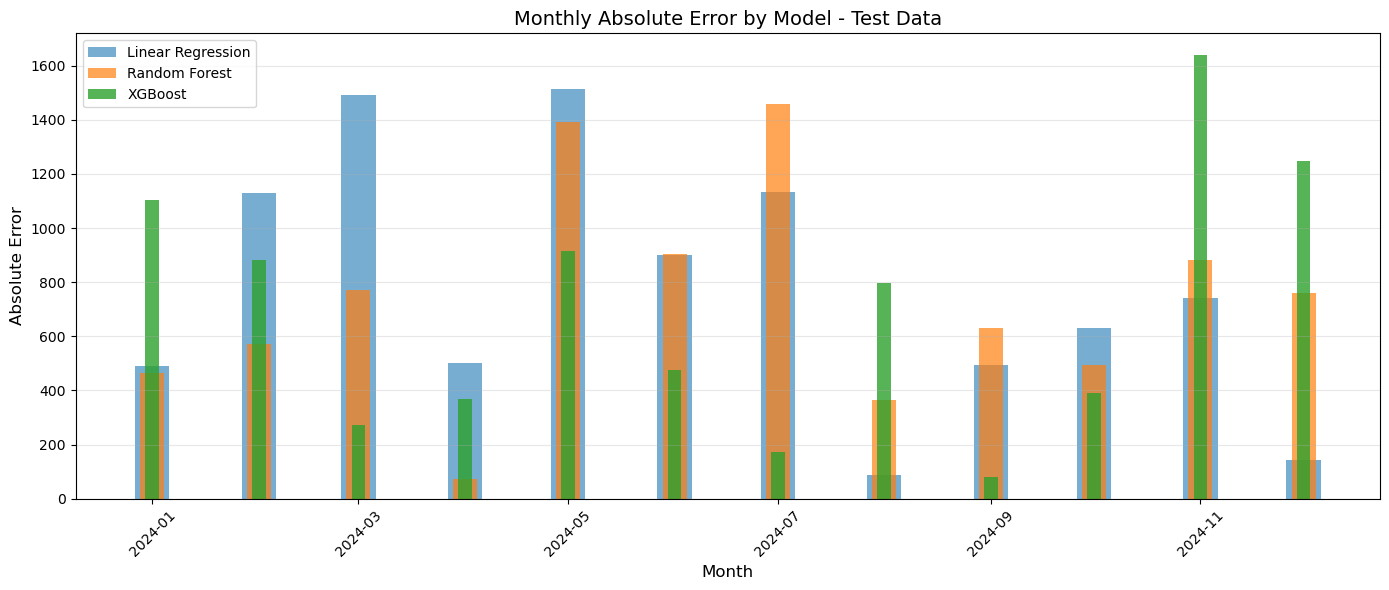

In [83]:
# 2. MODEL PERFORMANCE BY MONTH
# ============================

# Calculate monthly MAE for each model (test data)
monthly_test["lr_mae"] = abs(monthly_test["crime_count"] - monthly_test["lr_pred"])
monthly_test["rf_mae"] = abs(monthly_test["crime_count"] - monthly_test["rf_pred"])
monthly_test["xg_mae"] = abs(monthly_test["crime_count"] - monthly_test["xg_pred"])

# Plot MAE by month
plt.figure(figsize=(14, 6))
plt.bar(
    monthly_test["date"],
    monthly_test["lr_mae"],
    width=10,
    alpha=0.6,
    label="Linear Regression",
)
plt.bar(
    monthly_test["date"],
    monthly_test["rf_mae"],
    width=7,
    alpha=0.7,
    label="Random Forest",
)
plt.bar(
    monthly_test["date"], monthly_test["xg_mae"], width=4, alpha=0.8, label="XGBoost"
)
plt.title("Monthly Absolute Error by Model - Test Data", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_absolute_error_by_model_test_data.pdf", format="pdf")
plt.show()

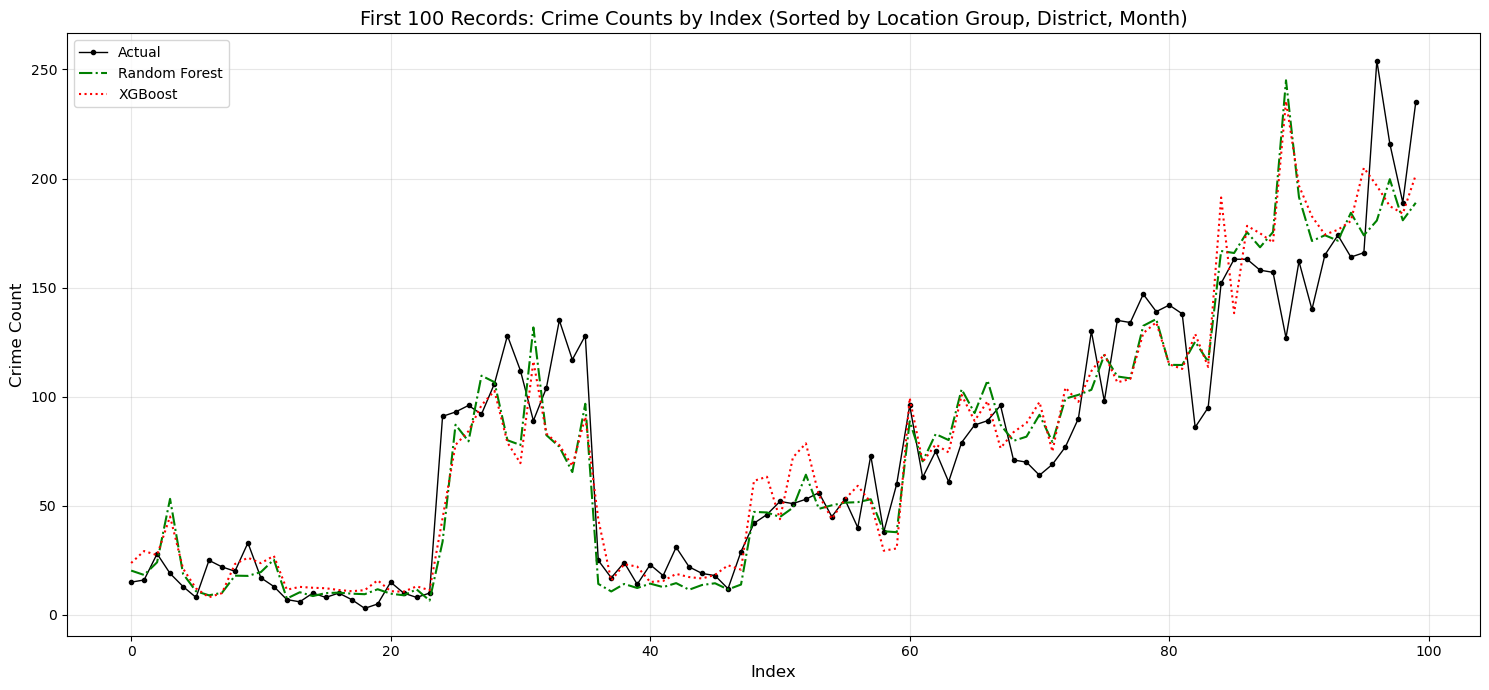

In [84]:
# 3. Plots based on index (first 100 indexes)

# Sort the test dataframe by a specific column (e.g., by District, then Month)
sorted_df = df_test.sort_values(["District", "Location Group", "Month"]).reset_index(
    drop=True
)

plt.figure(figsize=(15, 7))
plt.plot(
    sorted_df.index[:100],
    sorted_df["crime_count"][:100],
    marker="o",
    markersize=3,
    linewidth=1,
    label="Actual",
    color="black",
)
# plt.plot(sorted_df.index[:100], sorted_df['lr_pred'][:100], marker='', linestyle='--', label='Linear Regression', color='blue')
plt.plot(
    sorted_df.index[:100],
    sorted_df["rf_pred"][:100],
    marker="",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    sorted_df.index[:100],
    sorted_df["xg_pred"][:100],
    marker="",
    linestyle=":",
    label="XGBoost",
    color="red",
)

plt.title(
    "First 100 Records: Crime Counts by Index (Sorted by Location Group, District, Month)",
    fontsize=14,
)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("./figure/first_100_records_crime_counts_by_index.pdf", format="pdf")
plt.show()

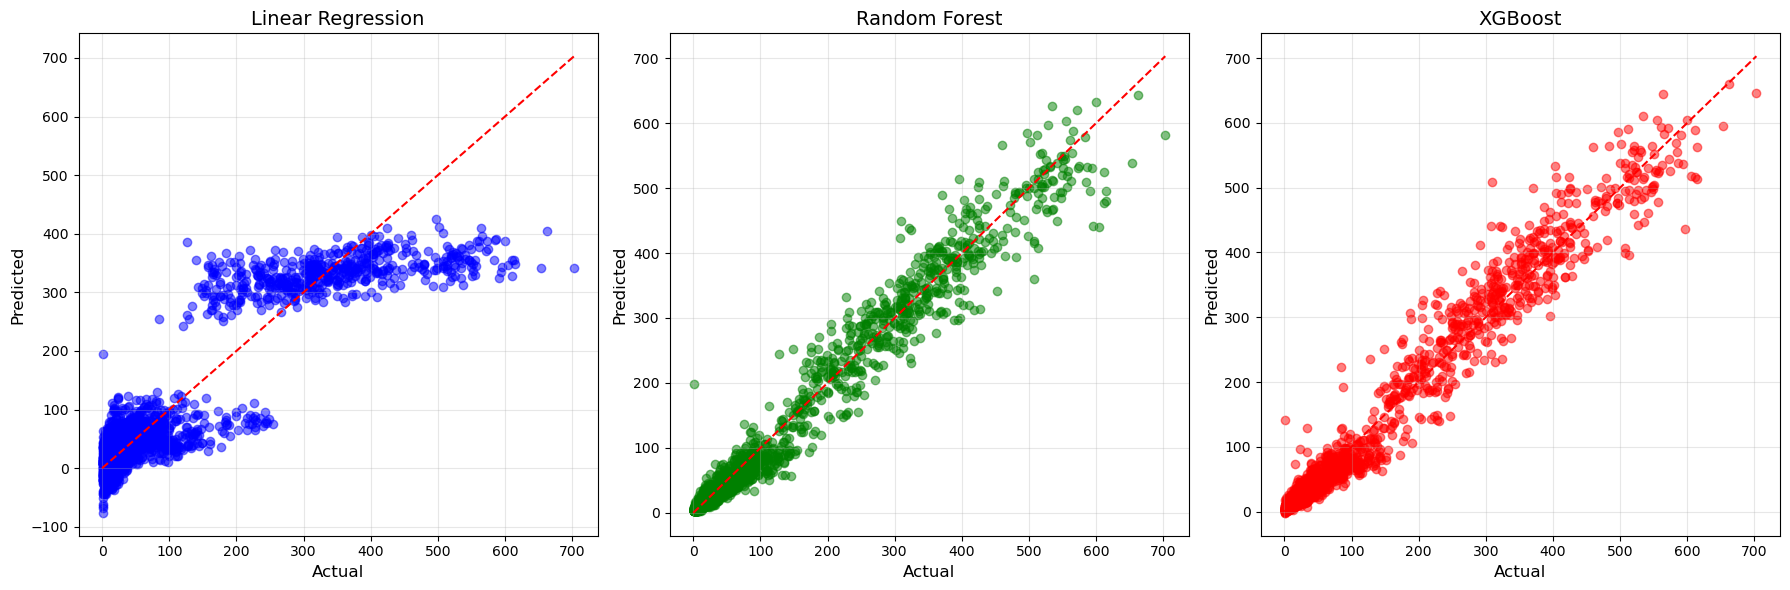

In [85]:
# 4. SCATTERPLOTS BY MODEL
# =======================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear Regression
axes[0].scatter(df_test["crime_count"], df_test["lr_pred"], alpha=0.5, color="blue")
axes[0].plot(
    [0, df_test["crime_count"].max()], [0, df_test["crime_count"].max()], "r--"
)
axes[0].set_title("Linear Regression", fontsize=14)
axes[0].set_xlabel("Actual", fontsize=12)
axes[0].set_ylabel("Predicted", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].scatter(df_test["crime_count"], df_test["rf_pred"], alpha=0.5, color="green")
axes[1].plot(
    [0, df_test["crime_count"].max()], [0, df_test["crime_count"].max()], "r--"
)
axes[1].set_title("Random Forest", fontsize=14)
axes[1].set_xlabel("Actual", fontsize=12)
axes[1].set_ylabel("Predicted", fontsize=12)
axes[1].grid(True, alpha=0.3)

# XGBoost
axes[2].scatter(df_test["crime_count"], df_test["xg_pred"], alpha=0.5, color="red")
axes[2].plot(
    [0, df_test["crime_count"].max()], [0, df_test["crime_count"].max()], "r--"
)
axes[2].set_title("XGBoost", fontsize=14)
axes[2].set_xlabel("Actual", fontsize=12)
axes[2].set_ylabel("Predicted", fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figure/scatterplots_by_model_test_data.pdf", format="pdf")
plt.show()

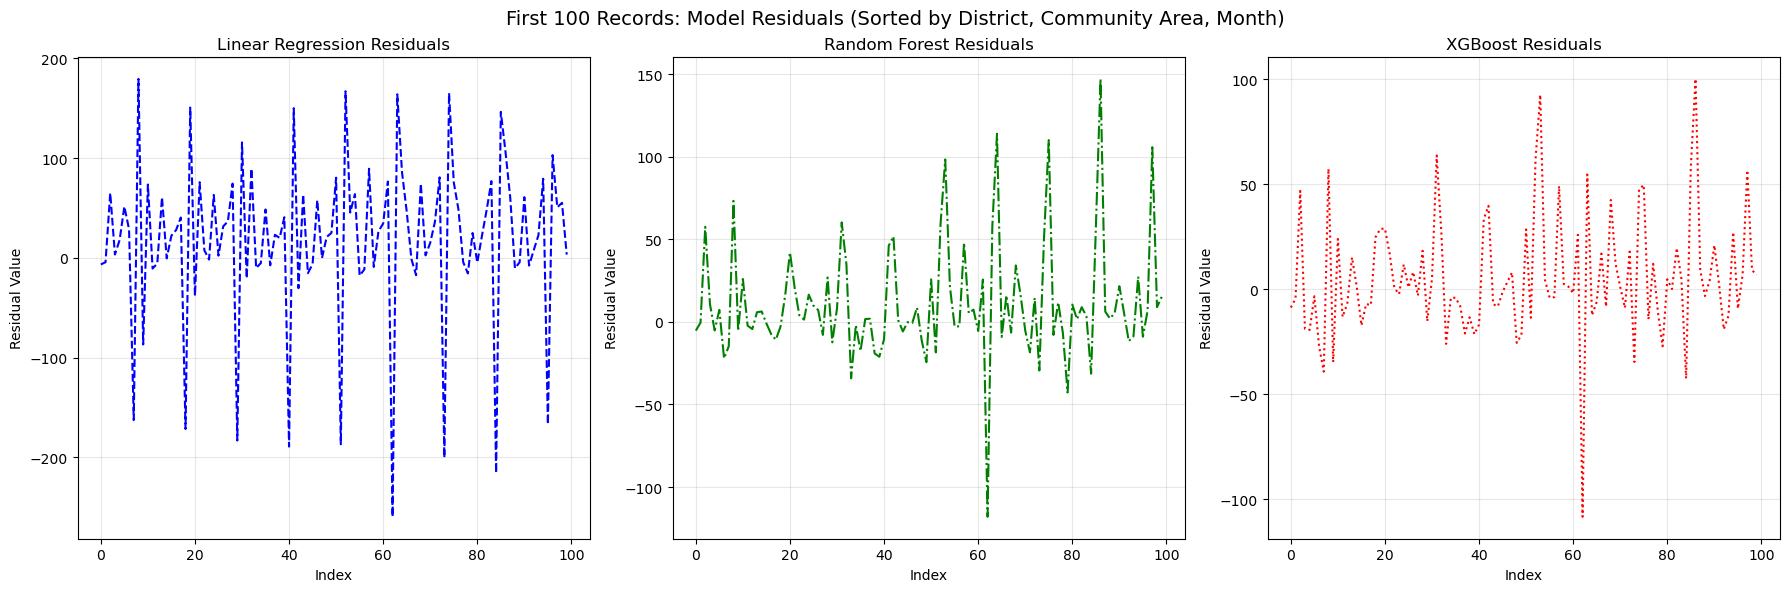

In [86]:
# 5. residuals plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sort dataframe
sorted_df = df_test.sort_values(["District", "Month"]).reset_index(drop=True)

# Plot Linear Regression residuals
axes[0].plot(
    sorted_df.index[:100],
    sorted_df["lr_res"][:100],
    marker="",
    linestyle="--",
    color="blue",
)
axes[0].set_title("Linear Regression Residuals")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Residual Value")
axes[0].grid(True, alpha=0.3)

# Plot Random Forest residuals
axes[1].plot(
    sorted_df.index[:100],
    sorted_df["rf_res"][:100],
    marker="",
    linestyle="-.",
    color="green",
)
axes[1].set_title("Random Forest Residuals")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Residual Value")
axes[1].grid(True, alpha=0.3)

# Plot XGBoost residuals
axes[2].plot(
    sorted_df.index[:100],
    sorted_df["xg_res"][:100],
    marker="",
    linestyle=":",
    color="red",
)
axes[2].set_title("XGBoost Residuals")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Residual Value")
axes[2].grid(True, alpha=0.3)

# Add a main title to the figure
fig.suptitle(
    "First 100 Records: Model Residuals (Sorted by District, Community Area, Month)",
    fontsize=14,
)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for the suptitle
plt.show()